In [1]:
import random

import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster                   # Algoritmos de clustering.
from sklearn import datasets                  # Crear datasets.
from sklearn import manifold                  # Algoritmos de reduccion de dimensionalidad.
from sklearn import decomposition             # Módulo de reducción de dimensionalidad.
from sklearn.utils import check_random_state  # Gestión de números aleatorios.

# Clustering jerárquico y dendrograma.
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.neighbors import NearestNeighbors

# UMAP para reducción de dimensionalidad.
import umap

# Visualizacion.
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import AffinityPropagation
import sys 
import os
sys.path.append(os.path.abspath('/home/fran/Escritorio/i3uex/education_drop_clustering/Code/analysis_and_modeling'))
import dunn_index
from sklearn import metrics

%matplotlib inline

In [2]:
analys_personal_data = pd.read_csv('../../../Data/For_analysis_and_modeling/2nd_quadrimester/analys_personal_data.csv',sep='|')

In [3]:
analys_personal_data.head()

,expediente,cod_plan,des_plan,anio_apertura_expediente,abandona,convocatoria_acceso,des_acceso,nota_admision_def,sexo,edad_acceso,distance,becario,cum_pass_ratio,cum_absent_ratio,std_deviation,cum_median,cum_pass_median,cum_fail_median
0,1,1623,GRADO EN INGENIERÍA CIVIL - CONSTRUCCIONES CIV...,2009-10,0,JUN,Selectividad,7.160,H,25,0.0000,N,0.166667,0.277778,1.531484,3.250,5.0,2.50
1,2,1623,GRADO EN INGENIERÍA CIVIL - CONSTRUCCIONES CIV...,2009-10,0,JUN,Selectividad,6.836,D,25,300.8896,S,0.235294,0.176471,1.990064,4.175,5.7,3.84
2,3,1623,GRADO EN INGENIERÍA CIVIL - CONSTRUCCIONES CIV...,2009-10,1,JUN,Formación Profesional,6.836,H,31,667.4084,S,0.312500,0.562500,1.566486,5.000,5.0,2.50
3,4,1623,GRADO EN INGENIERÍA CIVIL - CONSTRUCCIONES CIV...,2009-10,0,JUN,Formación Profesional,6.836,D,28,92.0223,N,0.166667,0.444444,1.345324,3.825,5.2,2.53
4,5,1623,GRADO EN INGENIERÍA CIVIL - CONSTRUCCIONES CIV...,2009-10,1,JUN,Selectividad,6.730,D,25,92.0223,N,0.263158,0.315789,1.850120,3.670,5.4,2.50


In [4]:
def le_dataset(dset, le_cols, cat_cols):
    from sklearn import preprocessing
    for col in cat_cols:
        le = preprocessing.LabelEncoder()
        le.fit(dset[col].cat.categories)
        le_cols.append(le)
        dset[col] = le.transform(dset[col])

In [5]:
def inverse_le_dataset(dset, le_cols, cat_cols):
    from sklearn import preprocessing
    i = 0
    for col in cat_cols:
        le = le_cols[i]
        from sklearn import preprocessing
        dset[col] = le.inverse_transform(dset[col])
        i +=1

In [6]:
def get_dunn_index(data, labels):
    from sklearn.metrics.pairwise import euclidean_distances
    distances = euclidean_distances(data)
    return dunn_index.dunn(labels,distances)
    

In [18]:
import pandas as pd
def get_impurity(dropout_cl0: pd.core.series.Series, dropout_cl1:pd.core.series.Series):
    impurity = -1
    n = len (dropout_cl0) + len (dropout_cl1)
    if len(dropout_cl0[dropout_cl0 == 0]) > len(dropout_cl0[dropout_cl0 == 1]):
        impurity = (len(dropout_cl0) - len(dropout_cl0[dropout_cl0 == 0]))/n
    else:
        impurity = (len(dropout_cl0) - len(dropout_cl0[dropout_cl0 == 1]))/n
    if len(dropout_cl1[dropout_cl1 == 0]) > len(dropout_cl1[dropout_cl1 == 1]):
        impurity = impurity + ((len(dropout_cl1) - len(dropout_cl1[dropout_cl1 == 0]))/n)
    else:
        impurity = impurity + ((len(dropout_cl1) - len(dropout_cl1[dropout_cl1 == 1]))/n)
        
    return impurity

In [7]:
for col in analys_personal_data.columns:
    if 'object' in str(analys_personal_data.dtypes[col]):
        analys_personal_data[col] = analys_personal_data[col].astype('category')
        
le_cols = []
cat_cols = analys_personal_data.select_dtypes('category').columns
analys_personal_data_model = analys_personal_data.copy()
le_dataset(analys_personal_data_model,le_cols,cat_cols)
analys_personal_data_model.head()

,expediente,cod_plan,des_plan,anio_apertura_expediente,abandona,convocatoria_acceso,des_acceso,nota_admision_def,sexo,edad_acceso,distance,becario,cum_pass_ratio,cum_absent_ratio,std_deviation,cum_median,cum_pass_median,cum_fail_median
0,1,1623,1,1,0,5,3,7.160,1,25,0.0000,0,0.166667,0.277778,1.531484,3.250,5.0,2.50
1,2,1623,1,1,0,5,3,6.836,0,25,300.8896,1,0.235294,0.176471,1.990064,4.175,5.7,3.84
2,3,1623,1,1,1,5,1,6.836,1,31,667.4084,1,0.312500,0.562500,1.566486,5.000,5.0,2.50
3,4,1623,1,1,0,5,1,6.836,0,28,92.0223,0,0.166667,0.444444,1.345324,3.825,5.2,2.53
4,5,1623,1,1,1,5,3,6.730,0,25,92.0223,0,0.263158,0.315789,1.850120,3.670,5.4,2.50


In [8]:
analys_personal_data_model.drop(['expediente','cod_plan','distance','abandona'],axis=1,inplace=True)

In [9]:
analys_personal_data_model.head()

,des_plan,anio_apertura_expediente,convocatoria_acceso,des_acceso,nota_admision_def,sexo,edad_acceso,becario,cum_pass_ratio,cum_absent_ratio,std_deviation,cum_median,cum_pass_median,cum_fail_median
0,1,1,5,3,7.160,1,25,0,0.166667,0.277778,1.531484,3.250,5.0,2.50
1,1,1,5,3,6.836,0,25,1,0.235294,0.176471,1.990064,4.175,5.7,3.84
2,1,1,5,1,6.836,1,31,1,0.312500,0.562500,1.566486,5.000,5.0,2.50
3,1,1,5,1,6.836,0,28,0,0.166667,0.444444,1.345324,3.825,5.2,2.53
4,1,1,5,3,6.730,0,25,0,0.263158,0.315789,1.850120,3.670,5.4,2.50


In [11]:
from sklearn import cluster
K = range(1, 10)
sse = []
for k in K:
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(analys_personal_data_model)
    sse.append(kmeans.inertia_)


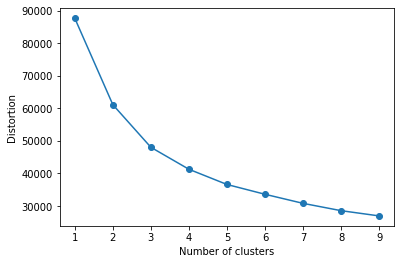

In [12]:
import matplotlib.pyplot as plt
plt.plot(K, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [13]:
kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(analys_personal_data_model)
analys_personal_data_clust = analys_personal_data_model.copy()
analys_personal_data_clust['labels'] = kmeans.predict(analys_personal_data_model)
analys_personal_data['labels'] = analys_personal_data_clust['labels'].astype('category')

In [14]:
metrics.silhouette_score(analys_personal_data_clust, analys_personal_data_clust['labels'])


0.28126853795045065

In [15]:
metrics.calinski_harabasz_score(analys_personal_data_clust, analys_personal_data_clust['labels'])


1006.3493465156972

In [16]:
metrics.davies_bouldin_score(analys_personal_data_clust, analys_personal_data_clust['labels'])


1.3544152875007658

In [17]:
get_dunn_index(analys_personal_data_clust,analys_personal_data_clust['labels'])

0.03128281840624444

In [19]:
analys_personal_data_clust['abandona'] = analys_personal_data['abandona']

In [20]:
get_impurity(analys_personal_data_clust[analys_personal_data_clust['labels']==0]['abandona'], analys_personal_data_clust[analys_personal_data_clust['labels']==1]['abandona'])

0.46323205636283576

In [21]:
# from apitep_utils.report import Report
# for label in analys_personal_data['labels'].cat.categories:
#     dset = analys_personal_data[analys_personal_data['labels'] == label]
#     report = Report()
#     report.generate_advanced(dset,'KMeans_1st_year_2_cl_'+str(label),sys.path[0]+ '/'+ '1st_year'+ str(label))